In [1]:
from models import regressionnet
from scripts import tools
from scripts import dataset
from scripts.config import *
import cv2

%matplotlib inline

tools.etc.set_GPU("2")

In [2]:
net_type = 'convnet1'
net, _, _, _ = regressionnet.create_regression_net(data_shape=(128,128,3),optimizer_type='adadelta',num_joints=14,net_type=net_type, gpu_memory_fraction=None)  

with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./snapshots/out/gpu0/convnet1_highest_pcp.ckpt")
    #saver.restore(net.sess, "./out/gpu1/convnet1.ckpt")
    #test_it = dataset.met("/var/data/MET3/activity-met_n10_ub_new_test.csv", Shuffle=False, dataset_root="./dataset/")
    test_it = dataset.met("/var/data/MET3/activity-met_n10_ub_new_test.csv", Shuffle=False, re_img_size=(128,128),
                          Bbox=True, Bbox_mode='apply', scale_set=[1.0], dataset_root="/var/data/MET3/")

INFO:tensorflow:Restoring parameters from ./snapshots/out/gpu0/convnet1_highest_pcp.ckpt


[ {{BBOX}} Applying Images & Coordinates]: 100%|██████████| 60/60 [00:00<00:00, 3137.53it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set.reshape(-1,14,2))
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)

In [4]:
class_pred_result = [[] for i in range(10)]
class_orig_result = [[] for i in range(10)]

class_name = ['Sleeping','Reclining','Seated.quiet','Standing.Relaxed','Reading.seated',
              'Writing', 'Typing', 'Filing.Seated','Filing.Stand','Walking about']

for i in range(len(pred_canonical)):
    class_pred_result[test_it.labels.squeeze()[i]].append(pred_canonical[i])
    class_orig_result[test_it.labels.squeeze()[i]].append(orig_canonical[i])
    
class_pred_result = np.array(class_pred_result)
class_orig_result = np.array(class_orig_result)

pcp_class_result = []

for i in range(len(class_pred_result)):
    pcp_value = tools.pose.eval_strict_pcp(class_orig_result[i],class_pred_result[i])
    pcp_class_result.append(tools.pose.average_pcp_left_right_limbs(pcp_value))
    
for i in range(len(class_pred_result)):
    print("Class : "+class_name[i])
    for j in range(len(pcp_class_result[i][1])):
        print(pcp_class_result[i][1][j]+" : "+str(pcp_class_result[i][0][j]))
    print("\n")

Class : Sleeping
Head : 0.3333333333333333
Torso : 0.8333333333333334
U Arm : 0.5833333333333333
L Arm : 0.5
U Leg : 0.8333333333333334
L Leg : 0.75
mean : 0.638888888888889


Class : Reclining
Head : 0.5
Torso : 1.0
U Arm : 0.5
L Arm : 0.41666666666666663
U Leg : 0.6666666666666666
L Leg : 0.9166666666666667
mean : 0.6666666666666666


Class : Seated.quiet
Head : 0.3333333333333333
Torso : 1.0
U Arm : 0.5
L Arm : 0.3333333333333333
U Leg : 0.6666666666666666
L Leg : 0.75
mean : 0.5972222222222222


Class : Standing.Relaxed
Head : 0.8333333333333334
Torso : 0.8333333333333334
U Arm : 0.41666666666666663
L Arm : 0.5
U Leg : 0.5833333333333333
L Leg : 0.75
mean : 0.6527777777777778


Class : Reading.seated
Head : 0.0
Torso : 0.6666666666666666
U Arm : 0.5
L Arm : 0.5
U Leg : 0.41666666666666663
L Leg : 0.6666666666666667
mean : 0.4583333333333333


Class : Writing
Head : 0.6666666666666666
Torso : 1.0
U Arm : 0.5833333333333333
L Arm : 0.08333333333333333
U Leg : 0.25
L Leg : 0.166666666

In [5]:
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
for i in range(len(average_pcp[1])):
    print(average_pcp[1][i]+" : "+str(average_pcp[0][i]))

Head : 0.4666666666666667
Torso : 0.8833333333333333
U Arm : 0.5583333333333333
L Arm : 0.45833333333333337
U Leg : 0.575
L Leg : 0.6166666666666667
mean : 0.5930555555555556


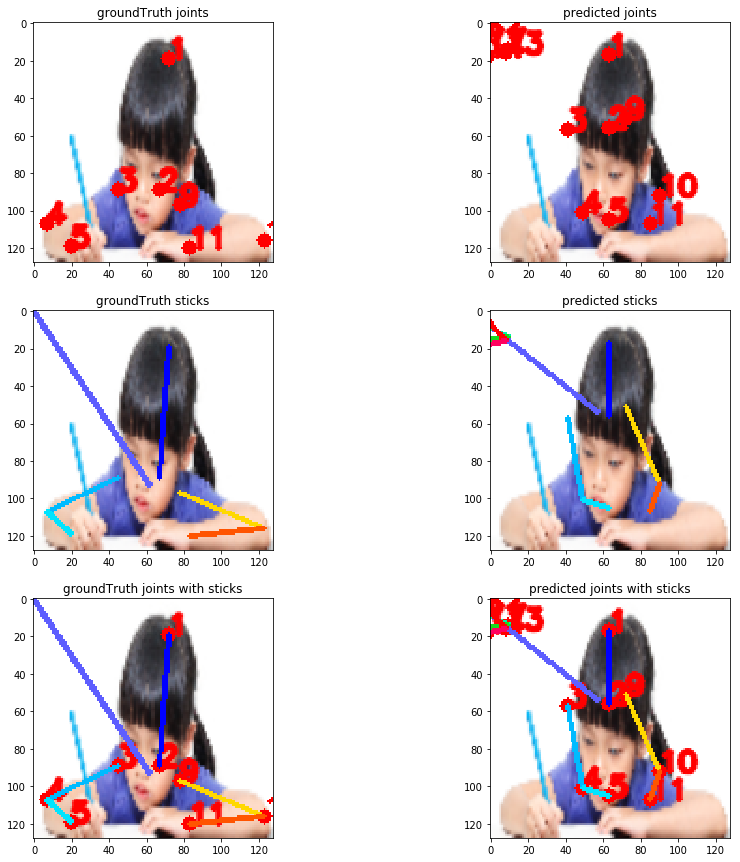

In [15]:
idx=9

tools.etc.demo_plot(test_it.img_set[idx], orig_canonical[idx], pred_canonical[idx])